# FNG-tungsten benchmark analysis 
*FNG-w* is a high quality neutronics experiment conducted to validate tungsten cross sections [1]. \
Neutronics code results are compared to the experiment measurements. \
Measurements include:
- Flux evaluation via activation foil reaction rate detection
- Nuclear heating via termoluminescent detector (TLD) measures

It is worth to mention that the OpenMC simulation relies on the _weight windows_ variance reduction technique. A local weight windows file (with _wwinp_ extension) has been produced through a CADIS simulation in Attila4MC [2].

Model, experimental results and MCNP results were provided by the SINBAD repository [3].

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import openmc_fusion_benchmarks as ofb
import helpers

### Extract experimental and codes results from `results_database`

In [2]:
# read sinbad data
experiment_file = ofb.ResultsFromDatabase('experiment.h5', path='results_database')
mcnp_eff2_file = ofb.ResultsFromDatabase('mcnp-4c_eff24.h5', path='results_database')
mcnp_fendl2_file = ofb.ResultsFromDatabase('mcnp-4c_fendl2.h5', path='results_database')

In [3]:
# get openmc results
openmc_fendl3_file = ofb.ResultsFromDatabase('openmc-0-14-0_fendl32b.h5', path='results_database')
openmc_endfb8_file = ofb.ResultsFromDatabase('openmc-0-14-0_endfb80.h5', path='results_database')

### Activation foils - reaction rate analysis
The following reaction rates are included:
- $^{93}Nb(n,2n)^{92m}Nb$
- $^{58}Ni(n,2n)^{57}Ni$
- $^{90}Zr(n,p)^{89}Zr$
- $^{27}Al(n,\alpha)^{24}Na$
- $^{56}Fe(n,p)^{56}Mn$
- $^{58}Ni(n,p)^{58}Co$
- $^{115}In(n,n')^{115m}Co$
- $^{197}Au(n,\gamma)^{198}Au$
- $^{55}Mn(n,\gamma)^{56}Mn$

OpenMC evaluation of the reaction rates relies on the **_IRDFF-II_** dosimetry nuclear data library [4]. While the rest of the transport relies on the nuclear data libraries specified in the legend of the plots. A _flux multiplier_ is applied to a _track-length flux_ tally is applied on the foil _cells_.

In [4]:
# initialize reaction rate plots
foil_list = ['nb93', 'ni58_n2n', 'zr90', 'al27', 'fe56', 'ni58_np', 'in115', 'au197', 'mn55']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{58}$Ni(n,2n)$^{57}$Ni', '$^{90}$Zr(n,2n)$^{89}$Zr', 
                   '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{56}$Fe(n,p)$^{56}$Mn', '$^{58}$Ni(n,p)$^{58}$Co', 
                   '$^{115}$In(n,n\')$^{115m}$In', '$^{197}$Au(n,\u03B3)$^{198}$Au', '$^{55}$Mn(n,\u03B3)$^{56}$Mn']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

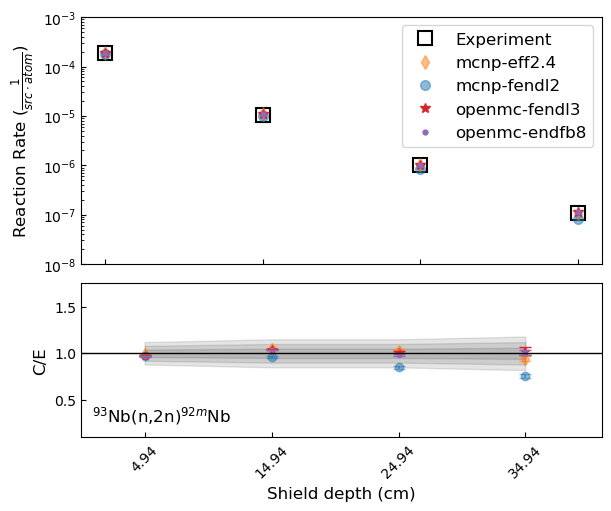

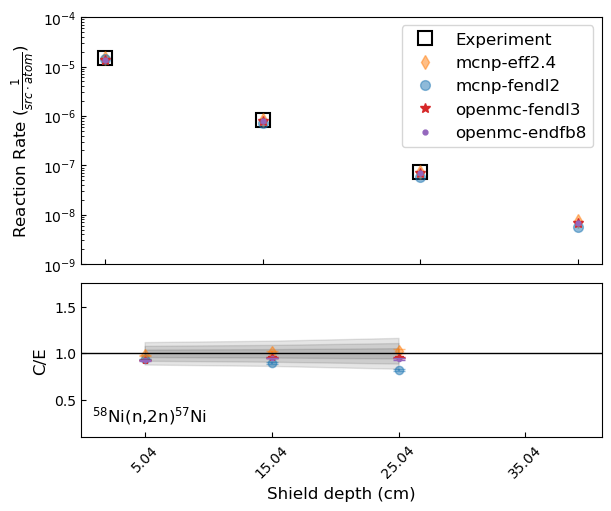

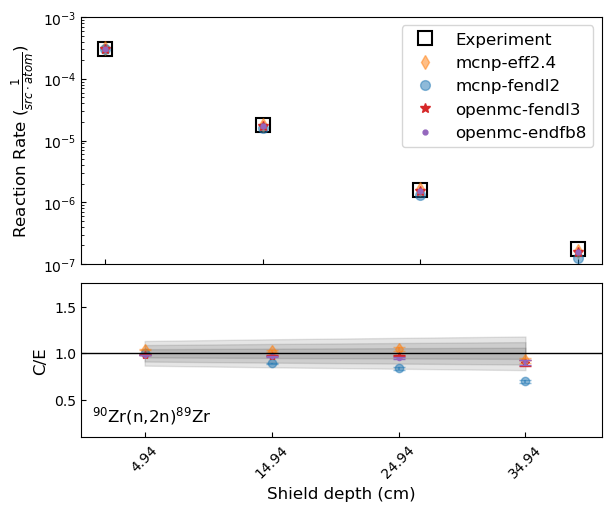

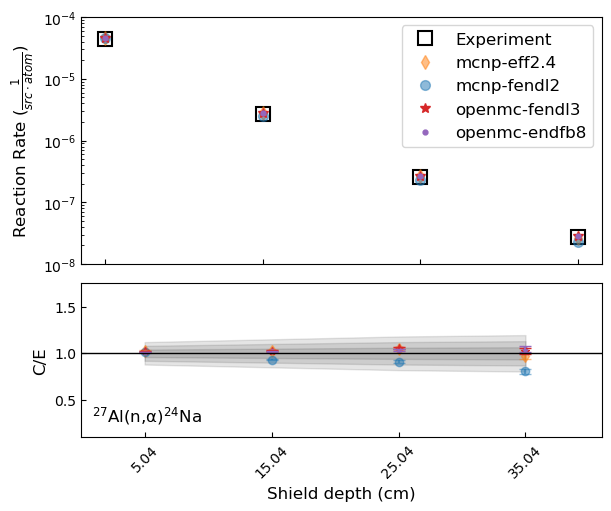

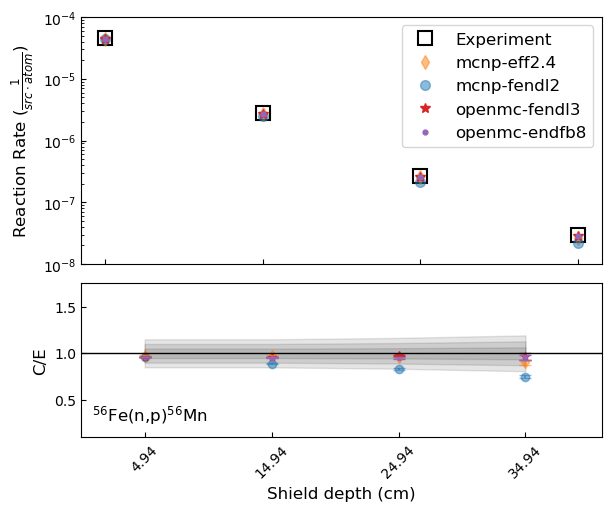

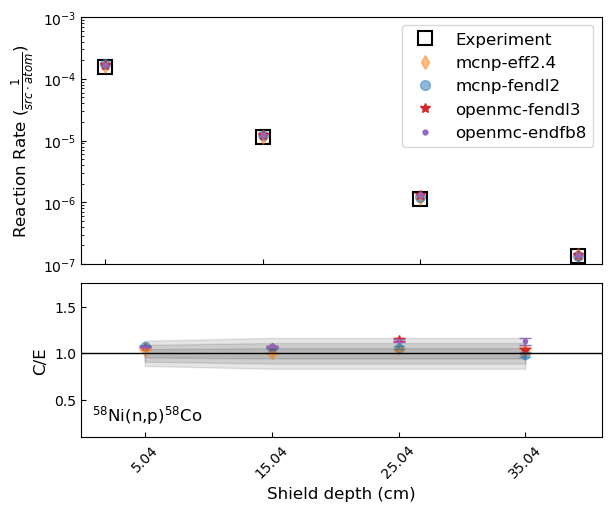

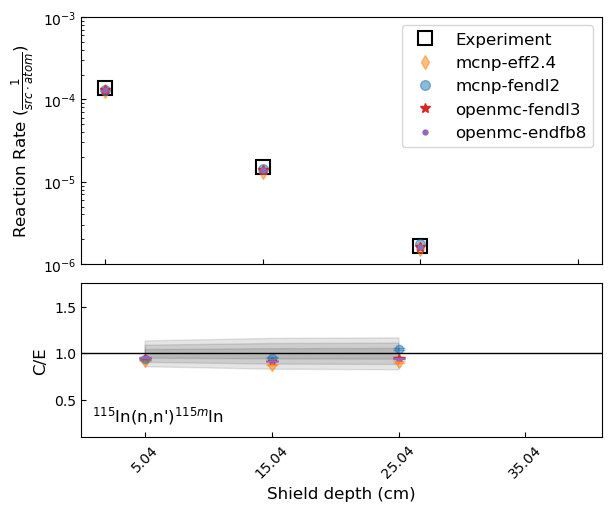

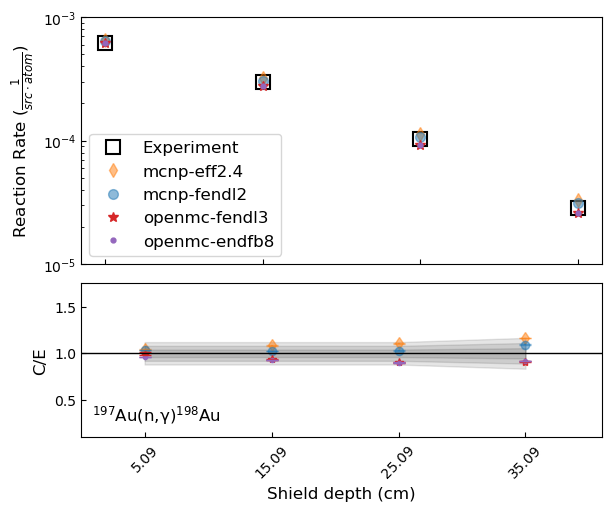

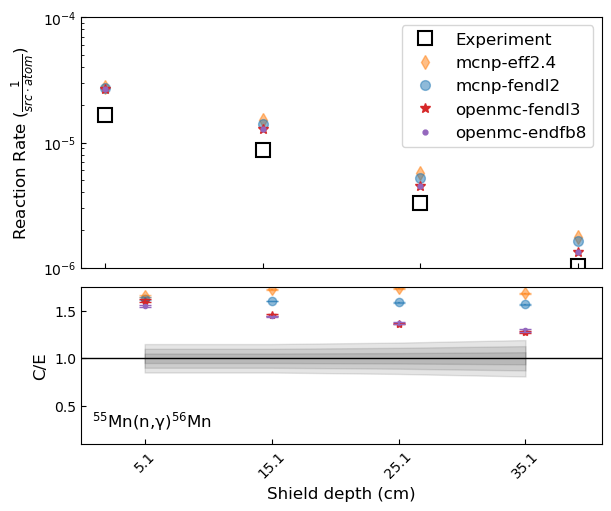

In [5]:
for i,foil in enumerate(foil_list):

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_{foil}')
    mcnp_eff2 = mcnp_eff2_file.get_tally_dataframe(f'rr_{foil}')
    mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'rr_{foil}')
    
    # openmc from results_database/
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'rr_{foil}')
    openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'rr_{foil}')
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    tickers = np.arange(len(measured))
    xaxis = experiment_file.get_tally_xaxis(f'rr_{foil}')
    means = [measured['mean'], mcnp_eff2['mean'], mcnp_fendl2['mean']]

    # generate figure
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

    # plot results
    ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
    ax1.plot(tickers, mcnp_eff2['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=.5, label='mcnp-eff2.4')
    ax1.plot(tickers, mcnp_fendl2['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=.5, label='mcnp-fendl2')

    # openmc results
    ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', alpha=1, label='openmc-fendl3')
    ax1.plot(tickers, openmc_fendl3['mean'], marker='.', ms=7, ls='none', color='tab:purple', label='openmc-endfb8')

    ofb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    ax2.errorbar(tickers, mcnp_eff2['mean']/measured['mean'], mcnp_eff2['std. dev.']/measured['mean'], 
                marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=.5, label='_label')
    ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
                marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=.5, label='_label')
    
    # openmc results
    ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'],
                marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', alpha=1, label='_label')
    ax2.errorbar(tickers, openmc_endfb8['mean']/measured['mean'], openmc_endfb8['std. dev.']/measured['mean'], 
                marker='.', ms=6, capsize=4, barsabove=True, color='tab:purple', ls='none', label='_label')

    # adjust
    ofb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
    ax1.set_yscale('log')
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.set_xticks(tickers)
    ax1.tick_params(axis='x', labelbottom=False)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.legend(fontsize=12)
    #
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                linewidth=1, label='_nolegend_')
    ax2.set_xlim([-0.5, tickers[-1] + .6])
    ax2.set_ylim([0.1, 1.75])
    ax2.set_xticks(tickers)
    ax2.set_xticklabels(measured[xaxis])
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='both', which='both', direction='in')
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel('C/E', fontsize=12)
    ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='bottom', fontsize=12)

As consequence of the energy self-shielding phenomenon observed in the fng-str benchmark, we carried out a sensitivity analysis of Mn reaction rates perturbing both gold and manganese concentrations in air in the activation foil cells. This time we did not observe a high sensitivy in the C/E values.

### Thermoluminescent detectors - nuclear heating analysis
Nuclear heating has been measured via thermoluminescent detectors which measured the dose deposited in _Gy/src_.

For this case, the OpenMC model featuring a _heating tally_ required _photon transport_ activated alongside _neutron transport_. The contributions of _neutrons_, _photons_, _electrons_ and _positrons_ have been evaluated.

In the fng-str benchmark calibration coefficients for the heating tallies were provided [3]. And the deposited dose (Q) was computed as follows:

$$Q = Q_n\cdot c_n\cdot c_e + \sum(Q_i)\cdot c_p  \tag{1}$$

where $Q_n$ is the neutron contribution and $\sum(Q_i)$ is the contribution of the other particles to the nuclear heating \
$C_n$ is the ratio of the TLD/material absorbed neutron dose \
$C_p$ is the ratio of the TLD/material absorbed photon dose \
$C_e$ is the TLD neutron dose efficiency with respect to the photon dose efficiency, taken from published data and weighted over the neutron spectra

The coefficients have not been provided for fng-w. However, we observed that $c_p$ is often equals to one while the order of magnitudes of $c_n$ and $c_e$ are $1e-1$ and $1e0$ respectively. We then applied equation (1) with these cofficient values.

This process is done in the `helpers` and it is automated in the `run_and_store` script.

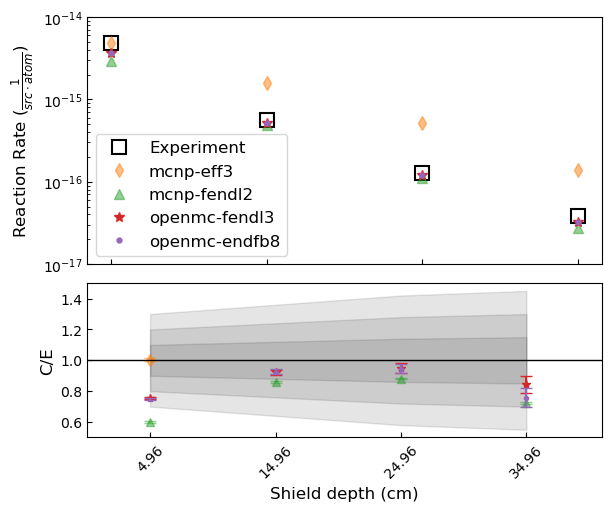

In [6]:
ylabel = r'Absorbed Dose $(\frac{Gy}{src})$'
# extract tallies
measured = experiment_file.get_tally_dataframe('nuclear_heating')
mcnp_eff2 = mcnp_eff2_file.get_tally_dataframe('nuclear_heating')
mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe('nuclear_heating')

# openmc from results_database
openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe('nuclear_heating')
openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe('nuclear_heating')

# plot
# preprocessing
dtype_label = reaction_labels[i]
tickers = np.arange(len(measured))
xaxis = experiment_file.get_tally_xaxis('nuclear_heating')
means = [measured['mean'], mcnp_eff2['mean'], mcnp_fendl2['mean']]

# generate figure
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

# plot results
ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
ax1.plot(tickers, mcnp_eff2['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=0.5, label='mcnp-eff3')
ax1.plot(tickers, mcnp_fendl2['mean'], marker='^', ms=7, ls='none', color='tab:green', alpha=0.5, label='mcnp-fendl2')

# openmc results
ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', alpha=1, label='openmc-fendl3')
ax1.plot(tickers, openmc_fendl3['mean'], marker='.', ms=7, ls='none', color='tab:purple', label='openmc-endfb8')

ofb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
ax2.errorbar(tickers, mcnp_eff2['mean']/measured['mean'], mcnp_eff2['std. dev.']/measured['mean'], 
            marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=0.5, label='_label')
ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
        marker='^', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', alpha=0.5, label='_label')
    
# openmc results
ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
        marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', alpha=1, label='_label')
ax2.errorbar(tickers, openmc_endfb8['mean']/measured['mean'], openmc_endfb8['std. dev.']/measured['mean'], 
                marker='.', ms=6, capsize=4, barsabove=True, color='tab:purple', ls='none', label='_label')

# adjust
ofb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
ax1.set_yscale('log')
ax1.set_ylabel(ylabel, fontsize=12)
ax1.set_xticks(tickers)
ax1.tick_params(axis='x', labelbottom=False)
ax1.tick_params(axis='both', which='both', direction='in')
ax1.legend(fontsize=12)
#
ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
            linewidth=1, label='_nolegend_')
ax2.set_xlim([-0.5, tickers[-1] + .6])
ax2.set_ylim([0.5, 1.5])
ax2.set_xticks(tickers)
ax2.set_xticklabels(measured[xaxis])
ax2.tick_params(axis='x', labelrotation=45)
ax2.tick_params(axis='both', which='both', direction='in')
ax2.set_xlabel(xaxis, fontsize=12)
ax2.set_ylabel('C/E', fontsize=12)

plt.show()

## References
[1] Batistoni, P., et al. "Neutronics benchmark experiment on tungsten." Journal of nuclear materials 329 (2004): 683-686. https://doi.org/10.1016/j.jnucmat.2004.04.191 \
[2] S. F. software, “Attila4MC” https://silverfirsoftware.com/Attila4MC.php (2023) \
[3] Kodeli, I. A., et al. "SINBAD–Radiation shielding benchmark experiments." Annals of Nuclear Energy 159 (2021): 108254. https://doi.org/10.1016/j.anucene.2021.108254 \
[4] Trkov, A., et al. "IRDFF-II: a new neutron metrology library." Nuclear Data Sheets 163 (2020): 1-108. https://doi.org/10.1016/j.nds.2019.12.001